# Finding Relative Value Trades - Deutsche Bank 

## Author : DEQUIDT Simon

In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import chain
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Bootstrapping - Zero-Coupon yields curve

In [9]:
market = pd.read_excel("Data.xls", sheet_name = 1, header = 2, index_col = 1, nrows = 52)
market.index.name = None

In [10]:
market

,Coupon Rate (%),Current Price
2/15/2004,3.000,101.0544
8/15/2004,2.125,100.9254
2/15/2005,1.500,99.8942
8/15/2005,6.500,109.0934
2/15/2006,5.625,108.4380
8/15/2006,2.375,99.7848
2/15/2007,6.250,111.7184
8/15/2007,3.250,101.0841
2/15/2008,3.000,99.1692
8/15/2008,3.250,99.2710


In [11]:
def getZCPrice(bondPrice, coupon, zcYieldV):
    if len(zcYieldV) != 0:
        for i in range(len(zcYieldV)):
            bondPrice -= coupon/2 / (1+zcYieldV[i]/2)**(i+1)
    return bondPrice / (100+coupon/2)
    
def getZCYield(zcPrice, i):
    return 2 * (1/(zcPrice)**(1/i) - 1)

In [12]:
zcYieldV = []

for i in range(len(market)):
    zcYieldV.append(getZCYield(getZCPrice(market["Current Price"][i], market["Coupon Rate (%)"][i], zcYieldV), i+1))
    
ts = pd.DataFrame(np.array(zcYieldV)*100, [(i+1)/2 for i in range(52)], ["ZC Yield (%)"])
ts

,ZC Yield (%)
0.5,0.881901
1.0,1.192962
1.5,1.575289
2.0,1.872718
2.5,2.174163
3.0,2.471112
3.5,2.790463
4.0,3.008378
4.5,3.254351
5.0,3.479914


To run the bootstrapping, we define two functions: 
   - **getZCPrice**: which returns the respective ZC bond price for a given coupon bond price using the ZC yields prior to the bond's maturity obtained recursively
   - **getZCYield**: which returns the ZC yield for a given ZC bond price.

To come up with the term structure, we simply have to run a for loop on the tenors, recursively adding the ZC Yields obtained from the ZC Prices at each step.

### Comparision of the zero-coupon yields from Deutsche Bank's model (in Exhibit 4 of the case) to the market zero-coupon yields

In [13]:
db = pd.read_excel("Data.xls", sheet_name = 2, header = 2, index_col = 0, nrows = 13)
db.index.name = None
db["Model Prediction (BEY)"] = db["Model Prediction (BEY)"].str.replace("%", "").astype(float)
db.index = db.index.str.replace("y","").astype(float)
db

,Model Prediction (BEY)
1.0,1.2443
2.0,1.8727
3.0,2.4110
4.0,2.9665
5.0,3.4454
6.0,3.8557
7.0,4.1996
8.0,4.4677
9.0,4.6528
10.0,4.7107


In [14]:
tsFiltered = ts.filter(items = db.index, axis = 0)
tsFiltered

,ZC Yield (%)
1.0,1.192962
2.0,1.872718
3.0,2.471112
4.0,3.008378
5.0,3.479914
6.0,3.881711
7.0,4.220336
8.0,4.486530
9.0,4.663971
10.0,4.710684


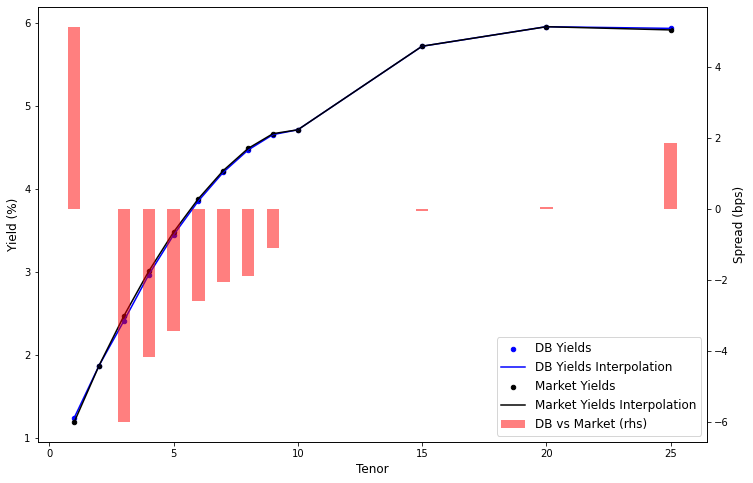

In [15]:
fig, ax1 = plt.subplots(figsize = (12,8))

ax1.scatter(db.index.values, db.iloc[:,0], label = "DB Yields", s = 20, color = "blue")
ax1.plot(db.iloc[:,0], label = "DB Yields Interpolation", color = "blue")

ax1.scatter(db.index.values, tsFiltered.iloc[:,0], label = "Market Yields", s = 20, color = "black")
ax1.plot(tsFiltered.iloc[:,0], label = "Market Yields Interpolation", color = "black")

ax1.set_xlabel("Tenor", fontsize = 12)
ax1.set_ylabel("Yield (%)", fontsize = 12)
ax1.tick_params("y")

ax2 = ax1.twinx()

ax2.bar(db.index, 100 * (db.iloc[:,0] - tsFiltered.iloc[:,0]), label = "DB vs Market (rhs)", color = "red", alpha = 0.5, width = 0.5)

ax2.set_ylabel("Spread (bps)", fontsize = 12)
ax2.tick_params("y")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = "lower right", fontsize = 12)

plt.show()

Comparision of the term structure infer from the market through to the tenors provided by DB's Model Prediction and plot the two curves.

We notice that the 1Y as well as the 25Y appear rich, while the maturities ranging from 3Y to 9Y appear rather cheap. Hence, DB should short the 1Y and 25Y ZCs and buy the ZCs ranging from 3Y to 9Y.

**Note that this strategy would not consist in a risk-free arbitrage, as it directly results from DB's Model Prediction and hence is directionnal.**

## Cubic splines

### Cubic splines’ function that uses as knots 2-, 5-,10-, 15- and 20-year zero-coupon yields.

In [16]:
knots1 = [0.5, 2, 5, 10, 15, 20, 26]
knotsYields1 = [ts.loc[knot].copy() for knot in knots1]

cubicSpline1 = CubicSpline(knots1, knotsYields1, bc_type="natural")
maturities = np.linspace(knots1[0], knots1[-1], 1000)
maturitiesYields1 = cubicSpline1(maturities)

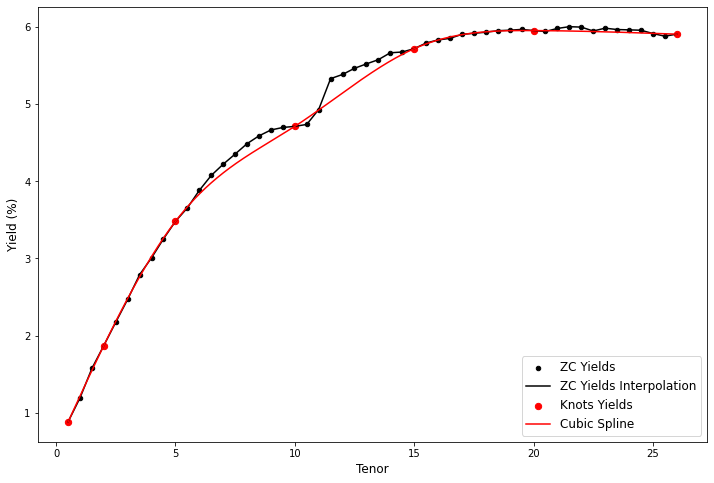

In [17]:
plt.figure(figsize = (12,8))

plt.scatter(ts.index, ts, label = "ZC Yields", s = 20, color = "black")
plt.plot(ts, label = "ZC Yields Interpolation", color = "black")

plt.scatter(knots1, knotsYields1, label = "Knots Yields", s = 40, color = "red")
plt.plot(maturities, maturitiesYields1, label = "Cubic Spline", color = "red")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Yield (%)", fontsize = 12)
plt.legend(loc = "lower right", fontsize = 12)

plt.show()

SciPy's CubicSpline function enables us to run the cubic spline methodology well describe in the literature. The latter consists in representing the curve as a series of cubic polynomials, that we then have to splice at some knot points, here the 2-5-10-15-20 maturity points. To come up with the cubic spline, one has to recursively solve for the solvable parameters along the knot points, and then estimate the coefficient of the shortest maturity as well as the unspecified coefficients in such that they minimize the total curvature of the cubic splines.

As said before, SciPy's CubicSpline function follows the described methodology and we only had to provide the chosen knot points as well as their respective ZC Yields. We notice that the resulting function is smoother than the bootstrapping, as it eliminated the irregularities ranging around the 10Y tenor.

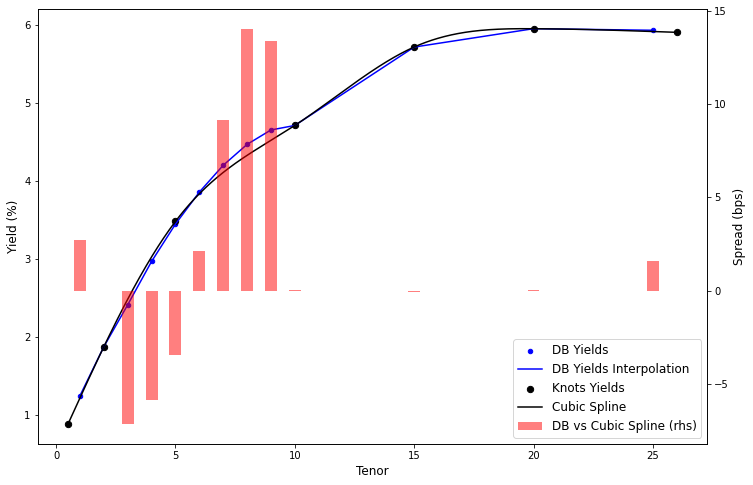

In [18]:
fig, ax1 = plt.subplots(figsize = (12,8))

ax1.scatter(db.index.values, db.iloc[:,0], label = "DB Yields", s = 20, color = "blue")
ax1.plot(db.iloc[:,0], label = "DB Yields Interpolation", color = "blue")

plt.scatter(knots1, knotsYields1, label = "Knots Yields", s = 40, color = "black")
plt.plot(maturities, maturitiesYields1, label = "Cubic Spline", color = "black")

ax1.set_xlabel("Tenor", fontsize = 12)
ax1.set_ylabel("Yield (%)", fontsize = 12)
ax1.tick_params("y")

ax2 = ax1.twinx()

ax2.bar(db.index, 100 * (db.iloc[:,0].values - cubicSpline1(db.index).T)[0], label = "DB vs Cubic Spline (rhs)", color = "red", alpha = 0.5, width = 0.5)

ax2.set_ylabel("Spread (bps)", fontsize = 12)
ax2.tick_params("y")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = "lower right", fontsize = 12)

plt.show()

The smoother aspect of the cubic spline we just highlighted has a significant impact when comparing its results to DB's Model Prediction. Indeed, while the 1Y and the 25Y still appear rather rich, the smoothering around the 10Y maturity entailed that maturities ranging from 6Y to 9Y now appear rich while the ones from 3Y to 5Y still appear cheap. Once again, DB should short the rich maturities and buy the cheap ones.

This is an other way to highlight the fact that the strategy is not risk-free: in addition to the fact that the strategy is directional as it directly follows DB's Model Prediction, it also relies on the choice of curve modelisation which directly implies the benchmark.

### Cubic splines’ function only using as knots 5- and 20-year zero-coupon yields

In [19]:
knots2 = [0.5, 5, 20, 26]
knotsYields2 = [ts.loc[knot].copy() for knot in knots2]

cubicSpline2 = CubicSpline(knots2, knotsYields2, bc_type="natural")
maturitiesYields2 = cubicSpline2(maturities)

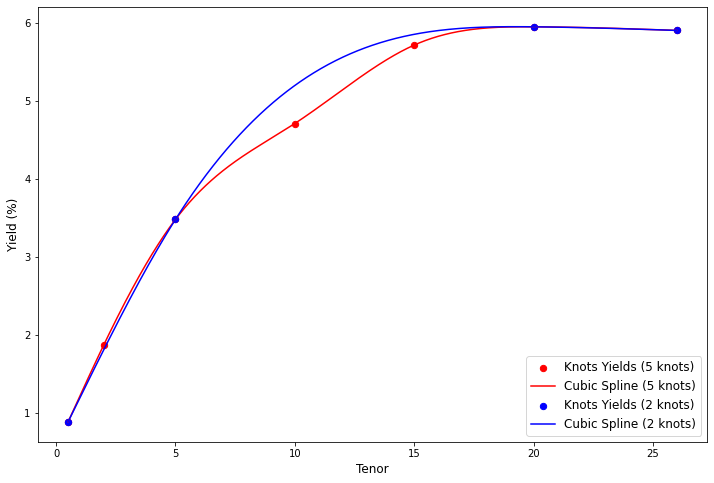

In [20]:
plt.figure(figsize = (12,8))

plt.scatter(knots1, knotsYields1, label = "Knots Yields (5 knots)", s = 40, color = "red")
plt.plot(maturities, maturitiesYields1, label = "Cubic Spline (5 knots)", color = "red")

plt.scatter(knots2, knotsYields2, label = "Knots Yields (2 knots)", s = 40, color = "blue")
plt.plot(maturities, maturitiesYields2, label = "Cubic Spline (2 knots)", color = "blue")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Yield (%)", fontsize = 12)
plt.legend(loc = "lower right", fontsize = 12)

plt.show()

As expected, the new cubic spline is a lot smoother than the previous one, as it relies on a lot less knot points and thus misses a lot of information relative to the shape of the term structure.

We will not once again compare these results to DB's Model Prediction, but the conclusions would have been the same as the ones in the previous conclusion with a new set of tenors appearing rich and cheap.

We can also understand from this point that selecting too many knot points on the other hand would lead to a significantly overfitted curve.

## Nelson Siegel model

### Discount function according to the Nelson-Siegel-Svensson model

In [21]:
def nelsonSiegelSvensson(time, beta0, beta1, beta2, beta3, theta, v):
    return beta0 + beta1 * ((1 - np.exp(-time/theta)) / (time/theta)) + \
            beta2 * ((1 - np.exp(-time/theta)) / (time/theta) - np.exp(-time/theta)) + \
            beta3 * ((1 - np.exp(-time/v)) / (time/v) - np.exp(-time/v))

In [22]:
initialization = [0.06, -0.4, -0.1, 0.1, 0.2, .03]

parameters, covariance = curve_fit(nelsonSiegelSvensson, ts.index.values, ts.iloc[:,0].values, p0 = initialization)
beta0, beta1, beta2, beta3, theta, v = parameters

nss = nelsonSiegelSvensson(ts.index.values, beta0, beta1, beta2, beta3, theta, v)

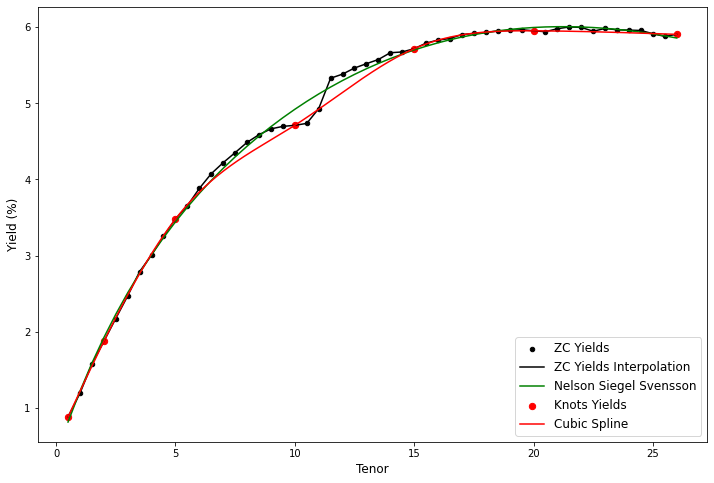

In [23]:
plt.figure(figsize = (12, 8))

plt.scatter(ts.index, ts, label = "ZC Yields", s = 20, color = "black")
plt.plot(ts, label = "ZC Yields Interpolation", color = "black")

plt.plot(ts.index.values, nss, label = "Nelson Siegel Svensson", color = "green")

plt.scatter(knots1, knotsYields1, label = "Knots Yields", s = 40, color = "red")
plt.plot(maturities, maturitiesYields1, label = "Cubic Spline", color = "red")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Yield (%)", fontsize = 12)
plt.legend(loc = "lower right", fontsize = 12)
plt.show()

We simply regress the term structure obtained from the market on the Nelson Siegel Svensson model. The curve we obtain once again is smoother than the bootstrapping as it erases the irregularities around the 10Y tenor.

Though let us note that, as its construction does not rely on the 10Y knot point, the 10Y area appears richer than the one of the cubic spline. This is an argument in favor of the Nelson Siegel Svensson model, as it is less likely to suffer from overfitting that may be caused by some outliers.

In [24]:
nssR2 = r2_score(ts.iloc[:,0].values, nss) * 100
print("Nelson Siegel Svensson R^2 : " + str(round(nssR2, 2)) + "%")

print("\n")

csR2 = r2_score(ts.iloc[:,0].values, cubicSpline1(ts.index.values)) * 100
print("Cubic Spline R^2 : " + str(round(csR2, 2)) + "%")

Nelson Siegel Svensson R^2 : 99.74%


Cubic Spline R^2 : 99.64%


The Nelson Siegel Svensson model has a better R^2 than cubic splines.

**Looking at the graph, this is indeed most likely due to the fact that the 10Y knot point forces the cubic spline curve to go a lot below a significant part of the term structure, while the Nelson Siegel Svensson curve follows the overall trend around that maturity.**

### Contributions from the different factors affecting the shape of the spot zero-coupon curve

In [25]:
level = beta0 * np.ones(len(ts.index.values))
slope = beta1 * ((1 - np.exp(-ts.index.values/theta)) / (ts.index.values/theta))
curvature = beta2 * ((1 - np.exp(-ts.index.values/theta)) / (ts.index.values/theta) - np.exp(-ts.index.values/theta)) + \
            beta3 * ((1 - np.exp(-ts.index.values/v)) / (ts.index.values/v) - np.exp(-ts.index.values/v))

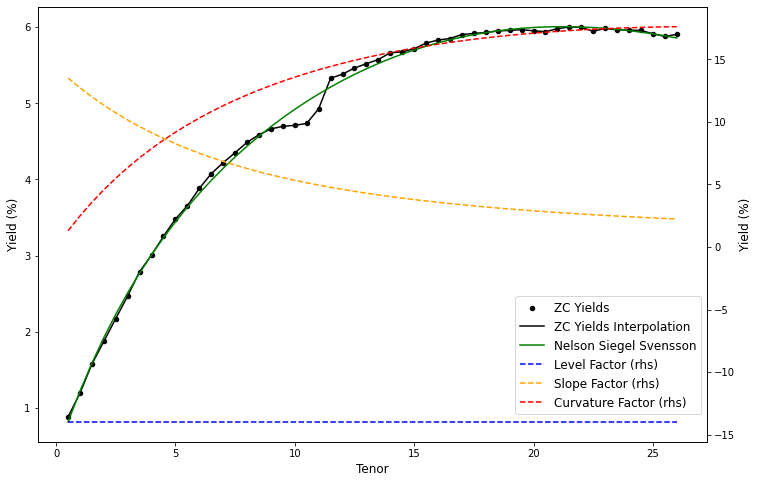

In [26]:
fig, ax1 = plt.subplots(figsize = (12,8))

plt.scatter(ts.index, ts, label = "ZC Yields", s = 20, color = "black")
plt.plot(ts, label = "ZC Yields Interpolation", color = "black")

plt.plot(ts.index.values, nss, label = "Nelson Siegel Svensson", color = "green")

ax1.set_xlabel("Tenor", fontsize = 12)
ax1.set_ylabel("Yield (%)", fontsize = 12)
ax1.tick_params("y")

ax2 = ax1.twinx()

ax2.plot(ts.index.values, level, label='Level Factor (rhs)', linestyle='--', color='blue')
ax2.plot(ts.index.values, slope, label='Slope Factor (rhs)', linestyle='--', color='orange')
ax2.plot(ts.index.values, curvature, label='Curvature Factor (rhs)', linestyle='--', color='red')

ax2.set_ylabel("Yield (%)", fontsize = 12)
ax2.tick_params("y")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = "lower right", fontsize = 12, bbox_to_anchor=(1, 0.05))

plt.show()

We simply use the formulae for the levels, slope and curvature factors implied by the Nelson Siegel Svensson model and plot them against the resulting curve.

**We notice that the level takes the form of a negative constant, the slope of a convexe curve and the curvature of a concave one.**

## Hedging

### Sensitivity to the 10-year rate, i.e., its 10-year key rate duration (KRD), when it rises by 50bps.

In [27]:
knotsYields3 = knotsYields1.copy()
knotsYields3[3] += 0.5

cubicSpline3 = CubicSpline(knots1, knotsYields3, bc_type="natural")
maturitiesYields3 = cubicSpline3(maturities)

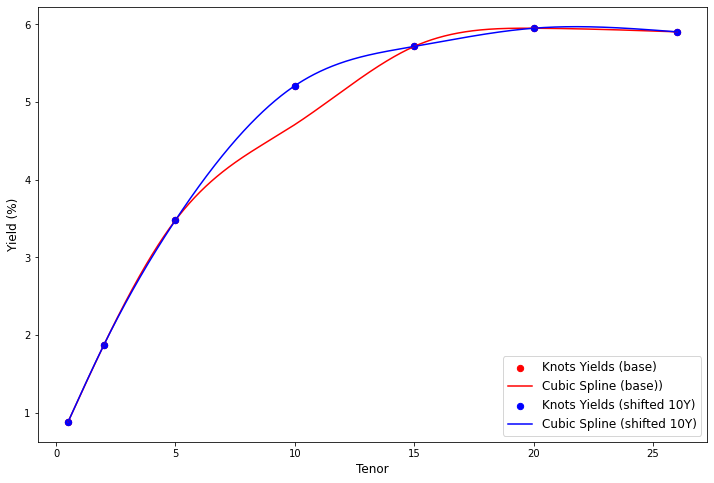

In [28]:
plt.figure(figsize = (12,8))

plt.scatter(knots1, knotsYields1, label = "Knots Yields (base)", s = 40, color = "red")
plt.plot(maturities, maturitiesYields1, label = "Cubic Spline (base))", color = "red")

plt.scatter(knots1, knotsYields3, label = "Knots Yields (shifted 10Y)", s = 40, color = "blue")
plt.plot(maturities, maturitiesYields3, label = "Cubic Spline (shifted 10Y)", color = "blue")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Yield (%)", fontsize = 12)
plt.legend(loc = "lower right", fontsize = 12)

plt.show()

We simply reapply the CubicSpline function from SciPy on the shifted term structure and plot the resulting curves.

Apart from the segment ranging around the 10Y tenor of the newly generated curve obviously yielding higher than the previous one, one can note that this also reduced the concavity of the curve on the 15Y-20Y segment. This ones again highlights the fact that cubic splines suffer from outliers as one bad datapoint has an impact on the whole curve.

### 1 million USD portfolio equally invested in all bonds - KRD of your portfolio 

In [29]:
def getBondPrice(maturity, coupon, zcYieldV):
    bondPrice = 0
    for i in range(int(2*maturity-1)):
        bondPrice += coupon/2 / (1+zcYieldV.iloc[i]/200)**(i+1)
    return bondPrice + (100+coupon/2) / (1+zcYieldV.loc[maturity]/200)**(2*maturity)

def equalWeights(bondPrices):
    n = len(bondPrices)
    portfolio = [1/n]*n
    portfolio = np.array([portfolio]) / np.array([bondPrices.iloc[:,0]])
    return list(chain(*portfolio))

def KRD(tenor, shift, bondList, initialAmount, weights, zcYieldV):
    bondPrices = pd.DataFrame([getBondPrice(bondList.iloc[i,0], bondList.iloc[i,1], zcYieldV) for i in range(len(bondList))]).T
    portfolio = weights(bondPrices)
    shiftedCurve = zcYieldV.copy()
    shiftedCurve.loc[tenor] +=  shift
    shiftedBondPrices = [getBondPrice(bondList.iloc[i,0], bondList.iloc[i,1], shiftedCurve) for i in range(len(bondList))]
    return sum(portfolio @ (shiftedBondPrices - bondPrices)) * initialAmount

In [30]:
bondList = pd.DataFrame([[(i+1)/2 for i in range(len(market))],[market.iloc[i,0] for i in range(len(market))]]).T

In [31]:
KRD(10, 0.5, bondList, 1e6, equalWeights, ts.iloc[:,0])

-68258.12737554223

In [32]:
50 * KRD(10, 0.01, bondList, 1e6, equalWeights, ts.iloc[:,0])

-69986.29158892173

To compute the 10Y key rate duration, we define three functions: 
   - **getBondPrice** : which returns the price of a bond given the latter's maturity and coupon rate and the term structure of our choice.
   - **equalWeights**: which returns the required weightings for an equally weighted portfolio of bonds given the latter's prices. 
   - **KRD** : which returns the sensitivity of a given shift at a given tenor for a portfolio, an initial amount and a term structure of our choice.

The rationale behind enabling the user to select the shift is to take into account the convexity: as one can see on the above results, the sensitivity for a 50 bps shift is smaller than 50 times the one for a 1 bp shift.

We will keep the same rationale in question 5 when providing our expected PnL.

### KRDs of your portfolio for all maturities - same shock individually to all zero-coupon yields

In [33]:
def allKRDs(shift, bondList, initialAmount, weights, zcYieldV):
    krdVector = []
    for tenor in bondList.iloc[:,0].values:
        krdVector.append(KRD(tenor, shift, bondList, initialAmount, weights, zcYieldV))
    krds = pd.DataFrame(krdVector, bondList.iloc[:,0], ["Sensitivity"])
    krds.index.name = None
    return krds

In [34]:
krds = allKRDs(0.01, bondList, 1e6, equalWeights, ts.iloc[:,0])

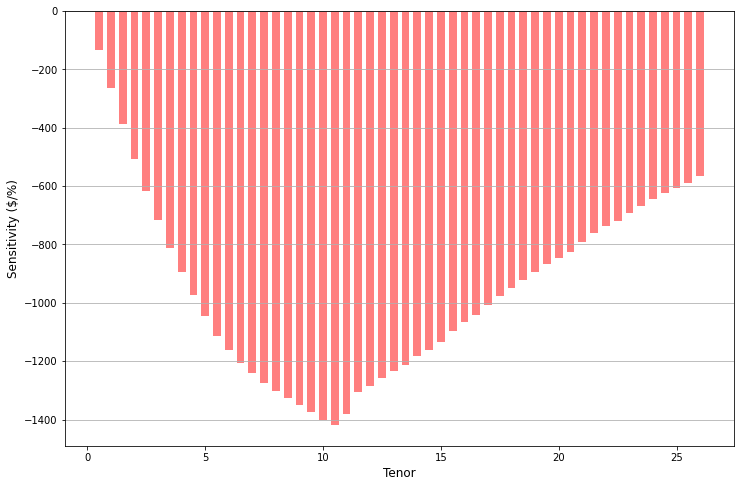

In [35]:
plt.figure(figsize = (12,8))

plt.bar(krds.index, krds.iloc[:,0], width = 0.33, color = "red", alpha = 0.5)

plt.grid(axis = "y")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Sensitivity ($/%)", fontsize = 12)
plt.show()

We simply define a allKRDs function, which provides the sensitivities for a given shift on each of the tenors for a portfolio, an initial amount and a term structure of our choice, and plot the ensuing results.

**We notice that the sensitivites are first quickly increasingly until they reach the 10.5Y tenor, and are then more slowly decreasing. Such a tendancy can be explained by two factors:**
   - **1. the sensitivity is the sum of two processes - on the one hand, a 1bp shift will be more impactful as the tenor and duration increases, on the other hand, as the tenor increases, a decreasing number of bonds are impacted by the shift**
   - **2. when looking at our term structure in Q1.1, we notce that it strongly increases and then reaches a plateau near the 10.5Y tenor, which hints at the fact that for the following tenors, the 1bp shift gets less impactful.**

## Portfolio strategy

### bootstrapped zero-coupon curve to steepen according to the following function, where 𝜀 is a random noise and 𝑇# is the average bond maturity
𝑦_new =𝑦 +[(𝑇−𝑇#)/𝑇#∗0.0050]+𝜀,𝜀~𝑁(0, 0.0025)

In [36]:
epsilon = np.random.normal(0, 0.25, len(ts.index))
T_mean = np.ones(len(ts))*np.mean(ts.index)

tsSteepening = ts.iloc[:,0] + (ts.index-T_mean)/T_mean * 0.50 + epsilon

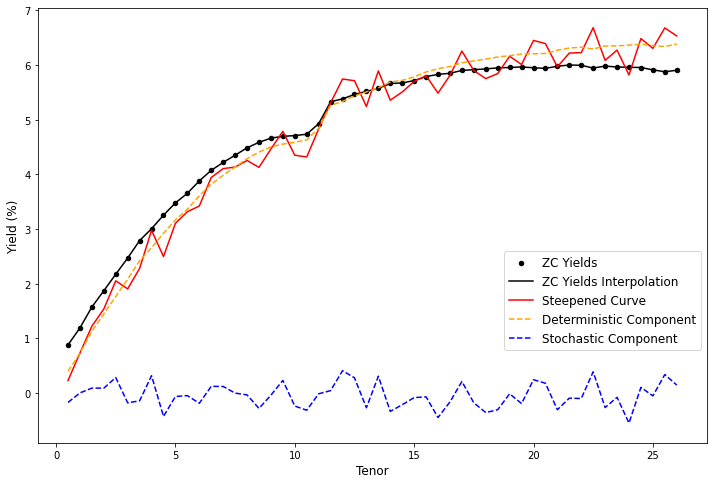

In [37]:
plt.figure(figsize = (12,8))

plt.scatter(ts.index, ts, label = "ZC Yields", s = 20, color = "black")
plt.plot(ts, label = "ZC Yields Interpolation", color = "black")

plt.plot(tsSteepening, label = "Steepened Curve", color = "red")
plt.plot(tsSteepening - epsilon, label = "Deterministic Component", linestyle = "--", color = "orange")
plt.plot(ts.index.values, epsilon, label = "Stochastic Component", linestyle = "--", color = "blue")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Yield (%)", fontsize = 12)
plt.legend(loc = "lower right", fontsize = 12, bbox_to_anchor=(1, 0.2))

plt.show()

We simply define the steepened curve as described and plot the latter against our term structure, and showcase the split between the deterministic and stochastic components.

### Discount function using the Nelson-Siegel-Svensson methodology

In [38]:
tsSteepeningMC = []
nssSteepeningMC = []

while len(nssSteepeningMC) != 1000:
    np.random.seed()
    try:
        epsilonMC = np.random.normal(0, 0.25, len(ts.index))
        tsSteepeningMC.append(ts.iloc[:,0].values + (ts.index.values-T_mean)/T_mean * 0.50 + epsilonMC)
        
        parameters2, covariance2 = curve_fit(nelsonSiegelSvensson, ts.index.values, tsSteepeningMC[-1], p0 = initialization)
        beta0_2, beta1_2, beta2_2, beta3_2, theta_2, v_2 = parameters2
        nssSteepeningMC.append(nelsonSiegelSvensson(ts.index.values, beta0_2, beta1_2, beta2_2, beta3_2, theta_2, v_2))
    except:
        tsSteepeningMC.pop()

<ipython-input-21-2800325fa656>:2: RuntimeWarning: overflow encountered in exp
  return beta0 + beta1 * ((1 - np.exp(-time/theta)) / (time/theta)) + \
<ipython-input-21-2800325fa656>:3: RuntimeWarning: overflow encountered in exp
  beta2 * ((1 - np.exp(-time/theta)) / (time/theta) - np.exp(-time/theta)) + \
<ipython-input-21-2800325fa656>:3: RuntimeWarning: invalid value encountered in subtract
  beta2 * ((1 - np.exp(-time/theta)) / (time/theta) - np.exp(-time/theta)) + \
<ipython-input-21-2800325fa656>:3: RuntimeWarning: overflow encountered in multiply
  beta2 * ((1 - np.exp(-time/theta)) / (time/theta) - np.exp(-time/theta)) + \
<ipython-input-21-2800325fa656>:4: RuntimeWarning: overflow encountered in exp
  beta3 * ((1 - np.exp(-time/v)) / (time/v) - np.exp(-time/v))
<ipython-input-21-2800325fa656>:4: RuntimeWarning: invalid value encountered in subtract
  beta3 * ((1 - np.exp(-time/v)) / (time/v) - np.exp(-time/v))
<ipython-input-21-2800325fa656>:4: RuntimeWarning: overflow encoun

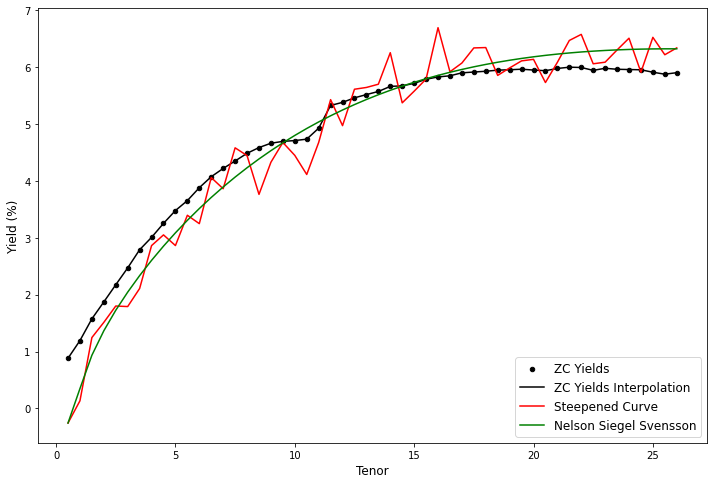

In [39]:
plt.figure(figsize = (12, 8))

plt.scatter(ts.index, ts, label = "ZC Yields", s = 20, color = "black")
plt.plot(ts, label = "ZC Yields Interpolation", color = "black")

plt.plot(ts.index.values, tsSteepeningMC[0], label = "Steepened Curve", color = "red")

plt.plot(ts.index.values, nssSteepeningMC[0], label = "Nelson Siegel Svensson", color = "green")

plt.xlabel("Tenor", fontsize = 12)
plt.ylabel("Yield (%)", fontsize = 12)
plt.legend(loc = "lower right", fontsize = 12)
plt.show()

In [40]:
bondPricesSteepeningMC = pd.DataFrame([[float(getBondPrice(bondList.iloc[j,0], bondList.iloc[j,1], pd.DataFrame(nssSteepeningMC[i],ts.index))) for j in range(len(bondList))] for i in range(1000)]).T

bondPricesSteepeningMC.index = ts.index
bondPricesSteepeningMC["Mean"] = bondPricesSteepeningMC.mean(axis = 1)

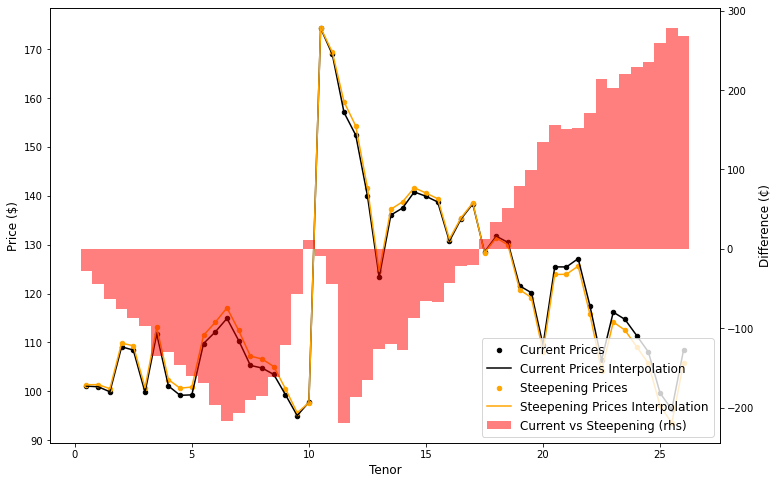

In [41]:
fig, ax1 = plt.subplots(figsize = (12,8))

ax1.scatter(ts.index.values, market.iloc[:,1].values, label = "Current Prices", s = 20, color = "black")
ax1.plot(ts.index.values, market.iloc[:,1].values, label = "Current Prices Interpolation", color = "black")

ax1.scatter(ts.index.values, bondPricesSteepeningMC.iloc[:,-1].values, label = "Steepening Prices", s = 20, color = "orange")
ax1.plot(ts.index.values, bondPricesSteepeningMC.iloc[:,-1].values, label = "Steepening Prices Interpolation", color = "orange")

ax1.set_xlabel("Tenor", fontsize = 12)
ax1.set_ylabel("Price ($)", fontsize = 12)
ax1.tick_params("y")

ax2 = ax1.twinx()

ax2.bar(ts.index.values, 100 * (market.iloc[:,1].values - bondPricesSteepeningMC.iloc[:,-1].values), label = "Current vs Steepening (rhs)", color = "red", alpha = 0.5, width = 0.5)

ax2.set_ylabel("Difference (₵)", fontsize = 12)
ax2.tick_params("y")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = "lower right", fontsize = 12)

plt.show()

**Methodology :**
   - Instead of simply generating one Nelson Siegel Svensson curve and computing the ensuing prices, which would imply a big bias in our results due to the stochastic component, we decided to use price the new bond prices via a Monte Carlo.

   - In particular, we first generate a thousand steepened term structures according to the formula given, and generate the ensuing Nelson Siegel Svensson curve for each of those term structures. We then price each of the bonds given the thousand Nelson Siegel Svensson curves, and average our results to come up with our so-called "Steepening Prices", which consists in the Monte Carlo prices for each of the bonds.

**Results :**
   - Thanks to this method, we are more confident when expressing our view. In particular, for each of the tenors on the above graph, a positive (resp. negative) Current vs Steepening bar implies that the current price is too rich (resp. cheap) given our view, and that one should short (resp. buy) it.

   - The overall result was to be expected, as our view implies a steepening of the curve and our results show an expected cheapining of the long end and richening of the short end. Note that the cheapening around the 10Y maturity can be explained by the irregularities that we highlighted around that point since the beginning of our study.

### Q5.3

In [42]:
steepeningPricesMC = np.array(bondPricesSteepeningMC.iloc[:,-1])

def strategyWeights(bondPrices, steepeningPrices = steepeningPricesMC):
    n = len(bondPrices)
    long = np.array([(steepeningPrices[i] - bondPrices[i]) if (steepeningPrices[i] - bondPrices[i]) > 0 else 0 for i in range(n)])
    short = np.array([(steepeningPrices[i] - bondPrices[i]) if (steepeningPrices[i] - bondPrices[i]) < 0 else 0 for i in range(n)])
    long = long * np.sum(np.abs(short))/np.sum(np.abs(long))
    portfolio = long + short
    portfolio = portfolio / np.sum(np.abs(portfolio))
    return portfolio

def strategyPnL(bondList, initialAmount, weights, zcYieldV, steepYieldV, steepeningPrices):
    bondPrices = np.array([getBondPrice(bondList.iloc[i,0], bondList.iloc[i,1], zcYieldV) for i in range(len(bondList))])
    portfolio = weights(bondPrices)
    return (pd.DataFrame(portfolio).T @ pd.DataFrame(steepeningPrices - bondPrices)).iloc[0,0] * initialAmount

In [43]:
print("Expected PnL: " + str(round(strategyPnL(bondList, 100, strategyWeights, ts.iloc[:,0], tsSteepening - epsilon, steepeningPricesMC),2)) + "$")

Expected PnL: 175.37$


**Methodology:**
   - We propose to build a 100% diversified zero-cost long-short portfolio with relative cheapness/richness proportional weightings.

        - In particular, the long (resp. short) portfolio is built such that it only contains the cheap (resp. rich) bonds and that the weighting of each bond is proportionnal to its cheapness (resp. richness). Before summing the two portfolios together, we make sure that they both have the same scale, i.e. that the sum of the absolute weightings are the same for each of the two portfolios, by rescaling one of the two via a cross product. We then sum the two portfolios and standardize the ensuing result to get our final portfolio weightings.

        - To compute our expected PnL, we define the strategyPnL function, which directly computes the expected PnL of the strategy by multiplying the expected shifts to the portfolio weights.

**Results:**
   - We obtain an expected PnL of 176.70. The strategy does not manage to generate the theoretical maximum of 200 as we decided to prioritize diversification and thus rescaled our underlying long and short portfolios rather than reducing the position on the long portfolio so that it matches the position of the short without the need to rescale. We do believe that in an out-of-sample framework, our strategy would provide a higher sharpe than the one we just descried, as one would not be able to efficiently decide which bonds to remove from the long portfolio and may suffer a loss from undiversifying.